In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lstm import LSTM1

cpu


In [3]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load data
df = pd.read_csv('crop_data.tsv', header=0, sep='\t')

cpu


In [4]:
df

,serial_no,date,weeks,temperature,humidity,moisture,illumination,leaf_len,leaf_num
0,1,2024-03-05 11:00:20,1,20,35,68,136,4.5,5
1,2,2024-03-05 11:30:26,1,21,35,67,131,4.5,5
2,3,2024-03-05 12:00:30,1,18,35,65,184,4.5,5
3,4,2024-03-05 12:30:34,1,18,35,64,156,4.5,5
4,5,2024-03-05 13:00:38,1,17,35,64,190,4.5,5
...,...,...,...,...,...,...,...,...,...
1232,1233,2024-04-01 07:30:21,5,18,33,3,151,6.0,11
1233,1234,2024-04-01 08:00:22,5,18,33,4,124,6.0,11
1234,1235,2024-04-01 08:30:23,5,18,33,2,110,6.0,11
1235,1236,2024-04-01 09:00:24,5,18,33,3,93,6.1,11


In [5]:
# convert to datetime type
df['date'] = pd.to_datetime(df['date'])

# Split year, month, day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.index = df['date']
df.drop(columns=['serial_no', 'year', 'month', 'day'], inplace=True)  # remove column
X, y = df[['weeks', 'temperature', 'humidity', 'moisture', 'illumination']], df[['leaf_num']]
print(X)
# Normalization and Scaling
mm = MinMaxScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(y)

# Train Data
X_train = X_mm[:int(len(X)*0.8), :]
X_test = X_mm[int(len(X)*0.8):, :]

# Test Data
y_train = y_mm[:int(len(X)*0.8), :]
y_test = y_mm[int(len(X)*0.8):, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


                     weeks  temperature  humidity  moisture  illumination
date                                                                     
2024-03-05 11:00:20      1           20        35        68           136
2024-03-05 11:30:26      1           21        35        67           131
2024-03-05 12:00:30      1           18        35        65           184
2024-03-05 12:30:34      1           18        35        64           156
2024-03-05 13:00:38      1           17        35        64           190
...                    ...          ...       ...       ...           ...
2024-04-01 07:30:21      5           18        33         3           151
2024-04-01 08:00:22      5           18        33         4           124
2024-04-01 08:30:23      5           18        33         2           110
2024-04-01 09:00:24      5           18        33         3            93
2024-04-01 09:30:25      5           18        33         3            83

[1237 rows x 5 columns]
Training Shap

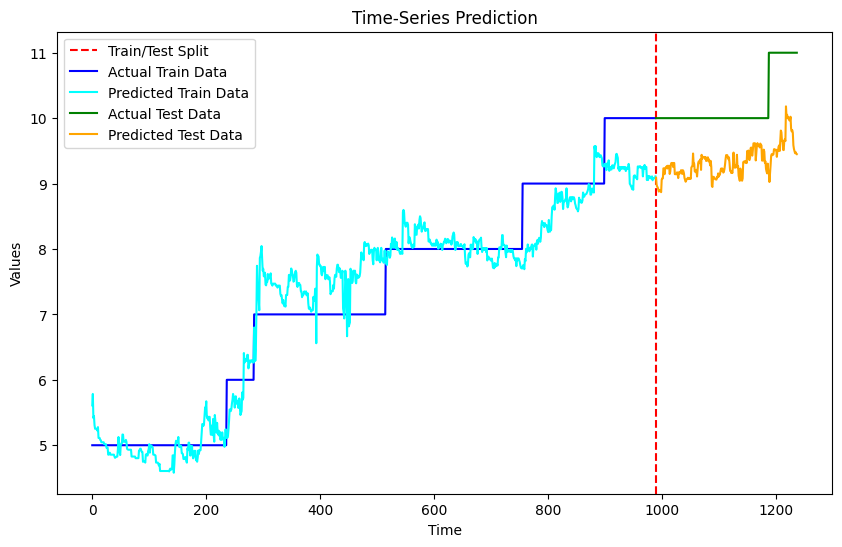

In [6]:
# Hyper parameters
num_epochs = 500
learning_rate = 0.0001
input_size = 5
hidden_size = 256
num_layers = 1
num_classes = 1


# 가중치 파일 불러오기
lstm_model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
lstm_model.load_state_dict(torch.load('lstm_model_ver02.pth', weights_only=True))
lstm_model.eval()  # 모델을 평가 모드로 전환

# 예측 수행 (학습 데이터에 대한 예측)
train_predict = lstm_model(X_train_tensors_final.to(device))
data_predict_train = train_predict.data.detach().cpu().numpy()
dataY_plot_train = y_train_tensors.data.numpy()
data_predict_train = mm.inverse_transform(data_predict_train)
dataY_plot_train = mm.inverse_transform(dataY_plot_train)

# 예측 수행 (테스트 데이터에 대한 예측)
test_predict = lstm_model(X_test_tensors_final.to(device))
data_predict_test = test_predict.data.detach().cpu().numpy()
dataY_plot_test = y_test_tensors.data.numpy()
data_predict_test = mm.inverse_transform(data_predict_test)
dataY_plot_test = mm.inverse_transform(dataY_plot_test)

# 시각화
plt.figure(figsize=(10, 6))
plt.axvline(x=len(dataY_plot_train), c='r', linestyle='--', label='Train/Test Split')

# 학습 데이터
plt.plot(dataY_plot_train, label='Actual Train Data', color='blue')  # 실제 학습 데이터
plt.plot(data_predict_train, label='Predicted Train Data', color='cyan')  # 예측된 학습 데이터

# 테스트 데이터
plt.plot(range(len(dataY_plot_train), len(dataY_plot_train) + len(dataY_plot_test)), dataY_plot_test, label='Actual Test Data', color='green')  # 실제 테스트 데이터
plt.plot(range(len(dataY_plot_train), len(dataY_plot_train) + len(dataY_plot_test)), data_predict_test, label='Predicted Test Data', color='orange')  # 예측된 테스트 데이터

# 라벨 및 범례
plt.title('Time-Series Prediction')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()
